In [1]:
library(ggplot2)
library(pscl)
library(MASS)
library(boot)

Classes and Methods for R developed in the
Political Science Computational Laboratory
Department of Political Science
Stanford University
Simon Jackman
hurdle and zeroinfl functions by Achim Zeileis


### Examples of zero-inflated negative binomial regression

### Description of the Data

In [2]:
zinb <- read.csv("./datasets/fish.csv")
zinb <- within(zinb, {
        nofish <- factor(nofish)
        livebait <- factor(livebait)
        camper <- factor(camper)
        })
summary(zinb)

 nofish  livebait camper     persons          child             xb           
 0:176   0: 34    0:103   Min.   :1.000   Min.   :0.000   Min.   :-3.275050  
 1: 74   1:216    1:147   1st Qu.:2.000   1st Qu.:0.000   1st Qu.: 0.008267  
                          Median :2.000   Median :0.000   Median : 0.954550  
                          Mean   :2.528   Mean   :0.684   Mean   : 0.973796  
                          3rd Qu.:4.000   3rd Qu.:1.000   3rd Qu.: 1.963855  
                          Max.   :4.000   Max.   :3.000   Max.   : 5.352674  
       zg              count        
 Min.   :-5.6259   Min.   :  0.000  
 1st Qu.:-1.2527   1st Qu.:  0.000  
 Median : 0.6051   Median :  0.000  
 Mean   : 0.2523   Mean   :  3.296  
 3rd Qu.: 1.9932   3rd Qu.:  2.000  
 Max.   : 4.2632   Max.   :149.000  

Warning message:
"Transformation introduced infinite values in continuous x-axis"`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 284 rows containing non-finite values (stat_bin)."

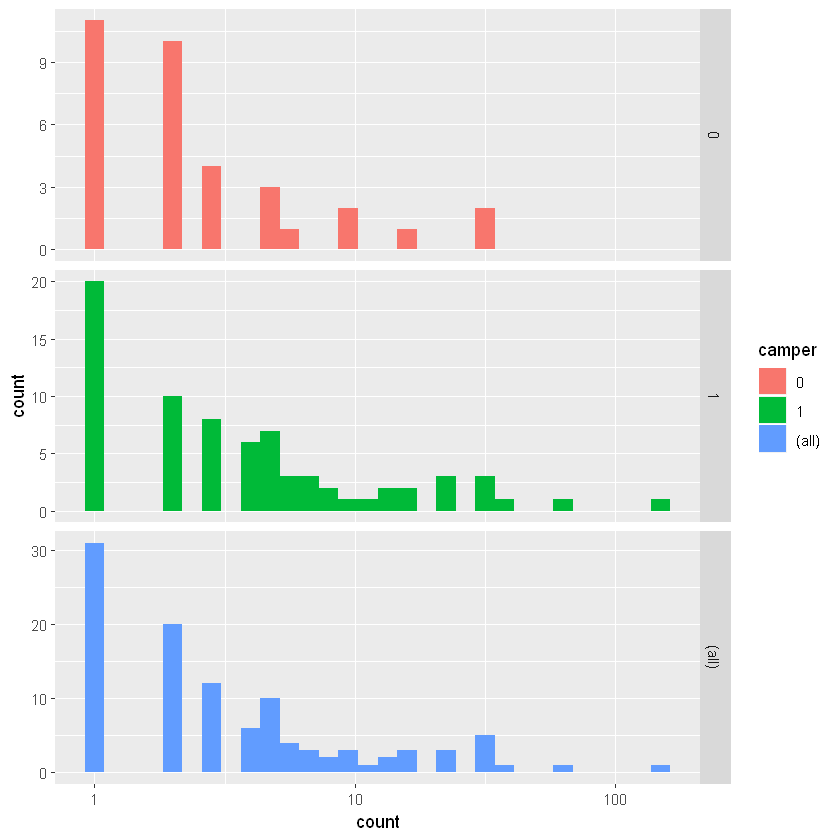

In [3]:
## histogram with x axis in log10 scale
ggplot(zinb, aes(count, fill = camper)) +
    geom_histogram() + scale_x_log10() + facet_grid(camper ~ ., margins=TRUE, scales="free_y")

### Analysis methods you might consider

### Zero-inflated negative binomial regression

A zero-inflated model assumes that zero outcome is due to two different processes. For instance, in the example of fishing presented here, the two processes are that a subject has gone fishing vs. not gone fishing. If not gone fishing, the only outcome possible is zero. If gone fishing, it is then a count process. The two parts of the a zero-inflated model are a binary model, usually a logit model to model which of the two processes the zero outcome is associated with and a count model, in this case, a negative binomial model, to model the count process. The expected count is expressed as a combination of the two processes. Taking the example of fishing again:

$ E(n_{\text{fish caught}} = k) = P(\text{not gone fishing}) * 0 + P(\text{gone fishing}) * E(y = k | \text{gone fishing})$ 

To understand the zero-inflated negative binomial regression, let's start with the negative binomial model. There are multiple parameterizations of the negative binomial model, we focus on NB2. The negative binomial probability density function is:

$ PDF(y; p, r) = \frac{(y_i + r - 1)!}{y_i!(r-1)!}p_{i}^{r}(1 - p_i)^{y_i} $

where \(p\) is the probability of \(r\) successes. From this we can derive the likelihood function, which is given by:

$ L(\mu; y, \alpha) = \prod_{i=1}^{n}exp\left(y_i ln\left(\frac{\alpha\mu_i}{1 + \alpha\mu_i}\right)-\frac{1}{\alpha}
ln(1 + \alpha\mu_i) + ln\Gamma(y_i + \frac{1}{\alpha})-ln\Gamma(y_i + 1) - ln\Gamma(\frac{1}{\alpha})\right) $ 

here we find the likelihood of the expected value, \(\mu\) given the data and \(\alpha\) which allows for dispersion. Typically, this would be expressed as a log likelihood, denoted by script L, \(\mathcal{L}\):

$ \mathcal{L}(\mu; y, \alpha) = \sum_{i=1}^{n}y_i ln\left(\frac{\alpha\mu_i}{1 + \alpha\mu_i}\right)-\frac{1}{\alpha}ln(1 + \alpha\mu_i) + ln\Gamma(y_i + \frac{1}{\alpha})-ln\Gamma(y_i + 1) - ln\Gamma(\frac{1}{\alpha}) $ 

which can be expressed in terms of our model by replacing \(\mu_i\) with \(exp(x_i^{'}\beta)\). Turning to the zero-inflated negative binomial model, the expression of the likelihood function depends on whether the observed value is a zero or greater than zero. From the logistic model of \(y_i > 1\) versus \(y = 0\):

$ p = \frac{1}{1 + e^{-x_{i}^{'}\beta}}$

and

$ 1 - p = \frac{1}{1 + e^{x_{i}^{'}\beta}} 4

then

$ \mathcal{L} = \sum_{i=1}^{n} \left\{ \begin{array}{rl} ln(p_{i}) + (1 - p_i)\left(\frac{1}{1 + \alpha\mu_{i}}\right)^{\frac{1}{\alpha}} & \mbox{if $y_{i} = 0$} \\ ln(p_{i}) + ln\Gamma\left(\frac{1}{\alpha} + y_i\right) - ln\Gamma(y_i + 1) - ln\Gamma\left(\frac{1}{\alpha}\right) + \left(\frac{1}{\alpha}\right)ln\left(\frac{1}{1 + \alpha\mu_{i}}\right) + y_iln\left(1 - \frac{1}{1 + \alpha\mu_{i}}\right) &\mbox{if $y_{i} > 0$} \end{array} \right. $ 

Finally, note that R does not estimate \(\alpha\) but \(\theta\), the inverse of \(\alpha\).

In [4]:
m1 <- zeroinfl(count ~ child + camper | persons,   data = zinb, dist = "negbin", EM = TRUE)
summary(m1)


Call:
zeroinfl(formula = count ~ child + camper | persons, data = zinb, dist = "negbin", 
    EM = TRUE)

Pearson residuals:
    Min      1Q  Median      3Q     Max 
-0.5861 -0.4617 -0.3886 -0.1974 18.0129 

Count model coefficients (negbin with log link):
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   1.3711     0.2561   5.353 8.63e-08 ***
child        -1.5152     0.1956  -7.747 9.42e-15 ***
camper1       0.8790     0.2693   3.264   0.0011 ** 
Log(theta)   -0.9854     0.1759  -5.600 2.14e-08 ***

Zero-inflation model coefficients (binomial with logit link):
            Estimate Std. Error z value Pr(>|z|)  
(Intercept)   1.6028     0.8363   1.916   0.0553 .
persons      -1.6663     0.6790  -2.454   0.0141 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Theta = 0.3733 
Number of iterations in BFGS optimization: 2 
Log-likelihood: -432.9 on 6 Df

In [5]:
m0 <- update(m1, . ~ 1)
pchisq(2 * (logLik(m1) - logLik(m0)), df = 3, lower.tail=FALSE)

'log Lik.' 1.280471e-13 (df=6)

In [6]:
summary(m2 <- glm.nb(count ~ child + camper, data = zinb))


Call:
glm.nb(formula = count ~ child + camper, data = zinb, init.theta = 0.2552931119, 
    link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3141  -1.0361  -0.7266  -0.1720   4.0163  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   1.0727     0.2425   4.424 9.69e-06 ***
child        -1.3753     0.1958  -7.025 2.14e-12 ***
camper1       0.9094     0.2836   3.206  0.00135 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for Negative Binomial(0.2553) family taken to be 1)

    Null deviance: 258.93  on 249  degrees of freedom
Residual deviance: 201.89  on 247  degrees of freedom
AIC: 887.42

Number of Fisher Scoring iterations: 1


              Theta:  0.2553 
          Std. Err.:  0.0329 

 2 x log-likelihood:  -879.4210 

In [7]:
vuong(m1, m2)

Vuong Non-Nested Hypothesis Test-Statistic: 
(test-statistic is asymptotically distributed N(0,1) under the
 null that the models are indistinguishible)
-------------------------------------------------------------
              Vuong z-statistic             H_A  p-value
Raw                   1.7017991 model1 > model2 0.044397
AIC-corrected         1.2026935 model1 > model2 0.114547
BIC-corrected         0.3239029 model1 > model2 0.373006


In [8]:
dput(round(coef(m1, "count"), 4))

c(`(Intercept)` = 1.3711, child = -1.5152, camper1 = 0.879)


In [9]:
dput(round(coef(m1, "zero"), 4))

c(`(Intercept)` = 1.6028, persons = -1.6663)


In [10]:
f <- function(data, i) {
     require(pscl)
     m <- zeroinfl(count ~ child + camper | persons,
     data = data[i, ], dist = "negbin",
     start = list(count = c(1.3711, -1.5152, 0.879), zero = c(1.6028, -1.6663)))
     as.vector(t(do.call(rbind, coef(summary(m)))[, 1:2]))}

set.seed(10)

(res <- boot(zinb, f, R = 1200, parallel = "snow", ncpus = 4))


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = zinb, statistic = f, R = 1200, parallel = "snow", 
    ncpus = 4)


Bootstrap Statistics :
       original       bias    std. error
t1*   1.3710504 -0.065280646  0.39732719
t2*   0.2561136 -0.002550328  0.03270754
t3*  -1.5152609 -0.051094308  0.26571813
t4*   0.1955916  0.005190813  0.01925923
t5*   0.8790522  0.067586346  0.47939903
t6*   0.2692734  0.001390551  0.02054443
t7*  -0.9853566  0.083109427  0.22661987
t8*   0.1759504  0.002732964  0.01653819
t9*   1.6031354  0.479700891  1.59419314
t10*  0.8365225  3.171881718 13.22891964
t11* -1.6665917 -0.440212365  1.53582837
t12*  0.6793077  3.177790255 13.26953284

In [11]:
## basic parameter estimates with percentile and bias adjusted CIs
parms <- t(sapply(c(1, 3, 5, 7, 9), function(i) {
         out <- boot.ci(res, index = c(i, i + 1), type = c("perc", "bca"))
                with(out, c(Est = t0, pLL = percent[4], pUL = percent[5], bcaLL = bca[4], bcaLL = bca[5]))}))

## add row names
row.names(parms) <- names(coef(m1))

## print results
parms

,Est,pLL,pUL,bcaLL,bcaLL
count_(Intercept),1.3710504,0.56762367,2.0619728,0.72263663,2.2923399
count_child,-1.5152609,-2.13817466,-1.0886883,-2.01750663,-0.9592912
count_camper1,0.8790522,0.04314645,1.8331288,-0.20155391,1.6669059
zero_(Intercept),-0.9853566,-1.28795522,-0.4430982,-1.50917647,-0.5961262
zero_persons,1.6031354,0.43444324,8.2379883,0.02821844,3.5197423


In [12]:
## compare with normal based approximation
confint(m1)

,2.5 %,97.5 %
count_(Intercept),0.86910572,1.8730573
count_child,-1.89860155,-1.1318879
count_camper1,0.35126797,1.4068178
zero_(Intercept),-0.03635521,3.2418992
zero_persons,-2.99701357,-0.3354987


In [13]:
## exponentiated parameter estimates with percentile and bias adjusted CIs
expparms <- t(sapply(c(1, 3, 5, 7, 9), function(i) {
            out <- boot.ci(res, index = c(i, i + 1), type = c("perc", "bca"), h = exp)
                   with(out, c(Est = t0, pLL = percent[4], pUL = percent[5], bcaLL = bca[4], bcaLL = bca[5]))}))

## add row names
row.names(expparms) <- names(coef(m1))

## print results
expparms

,Est,pLL,pUL,bcaLL,bcaLL
count_(Intercept),3.9394864,1.7640705,7.8614638,2.0598571,9.8980709
count_child,0.2197509,0.1178700,0.3366578,0.1329866,0.3831644
count_camper1,2.4086158,1.0440914,6.2534316,0.8174595,5.2957571
zero_(Intercept),0.3733061,0.2758342,0.6420442,0.2210920,0.5509417
zero_persons,4.9685866,1.5441034,3781.9642312,1.0286204,33.7757238


In [14]:
newdata1 <- expand.grid(0:3, factor(0:1), 1:4)
colnames(newdata1) <- c("child", "camper", "persons")
newdata1$phat <- predict(m1, newdata1)

ERROR: Error in +labs(x = "Number of Children", y = "Predicted Fish Caught"): 一元運算子的引數不正確


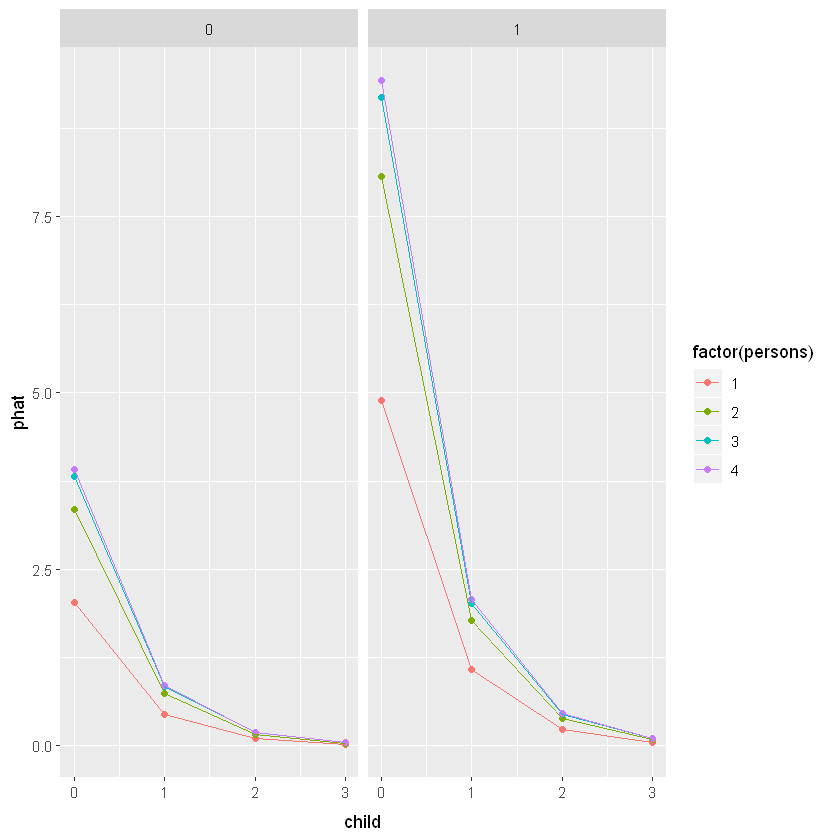

In [15]:
ggplot(newdata1, aes(x = child, y = phat, colour = factor(persons))) +
     geom_point() + geom_line() + facet_wrap(~camper) 
     + labs(x = "Number of Children", y = "Predicted Fish Caught")

### Things to consider